# Imports

In [75]:
import pandas as pd
import numpy as np
import chardet

import matplotlib
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_auc_score


# Leitura dos dados

In [3]:
with open('full_devices.csv', 'rb') as f:
    file_content = f.read()

    encoding = chardet.detect(file_content)['encoding']

In [4]:
df_devices = pd.read_csv('full_devices.csv', encoding=encoding)

In [5]:
df_devices

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...
124489,2015-11-02,Z1F0MA1S,0,18310224,0,0,0,10,353705,8,8,0
124490,2015-11-02,Z1F0Q8RT,0,172556680,96,107,4,11,332792,0,0,13
124491,2015-11-02,Z1F0QK05,0,19029120,4832,0,0,11,350410,0,0,0
124492,2015-11-02,Z1F0QL3N,0,226953408,0,0,0,12,358980,0,0,0


Fazendo uma contagem da target, percebemos que a mesma é extremamente desbalanceada.
Técnicas de classificação usuais não irão performar bem nesse caso

In [6]:
df_devices['failure'].value_counts(normalize=True)

0    0.999149
1    0.000851
Name: failure, dtype: float64

# Seleção de variáveis

Para uma seleção de variáveis, decidi utilizar a correlação das variáveis explicativas. Caso houvesse variáveis muito correlacionadas (>0.7), seria muito importante remover uma delas para não apresentar ao modelo informações duplicadas e evitar a multicolinearidade.

Caso duas variáveis fossem muito correlacionadas, precisaríamos decidir qual das duas menteriamos no modelo e meu critério de desempate seria o feature importance (v de cramer, pela target se tratar de uma variável binária).

Como nenhuma combinação de duas variáveis apresentou correlação alta, segui com todas para a modelagem.

In [9]:
df_devices[['attribute1', 'attribute2', 'attribute3',
       'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute8',
       'attribute9']].corr()

,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
attribute1,1.000000,-0.004250,0.003701,0.001836,-0.003376,-0.001522,0.000151,0.000151,0.001121
attribute2,-0.004250,1.000000,-0.002617,0.146593,-0.013999,-0.026350,0.141367,0.141367,-0.002736
attribute3,0.003701,-0.002617,1.000000,0.097452,-0.006696,0.009027,-0.001884,-0.001884,0.532366
attribute4,0.001836,0.146593,0.097452,1.000000,-0.009773,0.024870,0.045631,0.045631,0.036069
attribute5,-0.003376,-0.013999,-0.006696,-0.009773,1.000000,-0.017049,-0.009384,-0.009384,0.005949
attribute6,-0.001522,-0.026350,0.009027,0.024870,-0.017049,1.000000,-0.012207,-0.012207,0.021152
attribute7,0.000151,0.141367,-0.001884,0.045631,-0.009384,-0.012207,1.000000,1.000000,0.006861
attribute8,0.000151,0.141367,-0.001884,0.045631,-0.009384,-0.012207,1.000000,1.000000,0.006861
attribute9,0.001121,-0.002736,0.532366,0.036069,0.005949,0.021152,0.006861,0.006861,1.000000


# Train test split

In [10]:
X = df_devices[['date', 'device','attribute1', 'attribute2', 'attribute3',
       'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute8',
       'attribute9']]

In [11]:
Y = df_devices.failure

In [12]:
test_size = 0.30
seed = 0
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

# Treinamento do modelo

Decidi focar em estudar hiperparâmetros do método ao invés de testar outras classes de modelos, pois o ganho de performance, se houver, em outra classe muito possivelmente não seria muito significativo.

A vantagem de métodos baseados em árvore, é que eles costumam performar muito bem em tasks de classificação não balanceadas, capturam relações não lineares com a target e o pré-processamento dos dados requer menos cuidado. Um dos exemplos do pré-processamento para outros modelos como a regressão logística, seria ter que fazer uma padronização dos dados ou algum outro tipo de escalamento para que todos ficassem na mesma unidade de medida.

Escolhi o parametro de class weight do lgbm para lidar com o desbalanceamento dos dados. Basicamente, vamos dar pesos maiores para observações com target pouco frequentes e pesos menos para targets frequentes. Ou seja, observações com target 1 irão ter peso 0.999149 e obvervação com target 0 terão peso de 0.000851 (inversamente proporcional a ocorrencia das classes no conjunto de dados).

Em relação aos hiperparâmetros, testei 14 combinações entre learning rating e number of estimators. Para o learning rate (LR) vamos estar definindo o tamanho de cada passo entre as iterações, sendo que LR pequenos são muito custosos em termos de tempo de otimização e LR grandes são rápidos, porém podem deixar de encontrar otimizações precisas. Para o number of estimators, estaramos controlando o números de árvores que vão ser usadas na aprendizagem, sendo que um número pequeno pode trazer pouco aprendizado e um número grande pode trazer aprendizado excessivo (overfitting).

In [101]:
np.random.seed(0) # definindo uma semente global
num_folds=10
scoring='balanced_accuracy'

explicativas= ['attribute1', 'attribute2', 'attribute3',
       'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute8',
       'attribute9']

# Criação dos modelos
models = []
models.append(('modelo1', LGBMClassifier(class_weight='balanced',  learning_rate=0.1, n_estimators =100)))
models.append(('modelo2', LGBMClassifier(class_weight='balanced',  learning_rate=0.05, n_estimators =100)))
models.append(('modelo3', LGBMClassifier(class_weight='balanced',  learning_rate=0.01, n_estimators =100)))
models.append(('modelo4', LGBMClassifier(class_weight='balanced',  learning_rate=0.001, n_estimators =100)))
models.append(('modelo5', LGBMClassifier(class_weight='balanced',  learning_rate=0.2, n_estimators =100)))
models.append(('modelo6', LGBMClassifier(class_weight='balanced',  learning_rate=0.3, n_estimators =100)))
models.append(('modelo7', LGBMClassifier(class_weight='balanced',  learning_rate=0.4, n_estimators =100)))


models.append(('modelo8', LGBMClassifier(class_weight='balanced',  learning_rate=0.1, n_estimators =500)))
models.append(('modelo9', LGBMClassifier(class_weight='balanced',  learning_rate=0.05, n_estimators =500)))
models.append(('modelo10', LGBMClassifier(class_weight='balanced',  learning_rate=0.01, n_estimators =500)))
models.append(('modelo11', LGBMClassifier(class_weight='balanced',  learning_rate=0.001, n_estimators =500)))
models.append(('modelo12', LGBMClassifier(class_weight='balanced',  learning_rate=0.2, n_estimators = 500)))
models.append(('modelo13', LGBMClassifier(class_weight='balanced',  learning_rate=0.3, n_estimators =500)))
models.append(('modelo14', LGBMClassifier(class_weight='balanced',  learning_rate=0.4, n_estimators =500)))

# Avaliação dos modelos
results = []
names = []
for name, model in models:
  kfold = KFold(n_splits=num_folds)
  cv_results = cross_val_score(model, X_train[explicativas], Y_train, cv=kfold, scoring=scoring)
  results.append(cv_results)
  names.append(name)
#msg ="%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
#print(msg)

A saída de streaming foi truncada nas últimas 5000 linhas.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

Com base na validação cruzada para 10 folds, obtemos 10 métricas de acurácia balanceada para cada um dos 14 modelos. Aqui, optei por utilizar a acurácia balanceada, pois a mesma consegue lidar muito bem com targets desbalanceadas.

Na média, o modelo 4 acabou sendo o melhor, porém olhando os boxplots, observamos que o mesmo possui uma variabilidade grande. Com base nisso, optei pelo modelo 3 que em termos de média ficou muito parecido, porém o gráfico mostrou uma variabilidade muito menor em termos entre folds.

In [102]:
for i in range(0,14):
  print(f"{names[i]}: {results[i].mean()}")

modelo1: 0.5496050521158393
modelo2: 0.6283399570526531
modelo3: 0.7612425628587485
modelo4: 0.7632998820731507
modelo5: 0.5288393886260108
modelo6: 0.5122932816209438
modelo7: 0.5352444224604731
modelo8: 0.49987368067495036
modelo9: 0.4997932835988449
modelo10: 0.6372684974856216
modelo11: 0.7353479503952067
modelo12: 0.49987942516342826
modelo13: 0.49986793685016834
modelo14: 0.5123736793563495


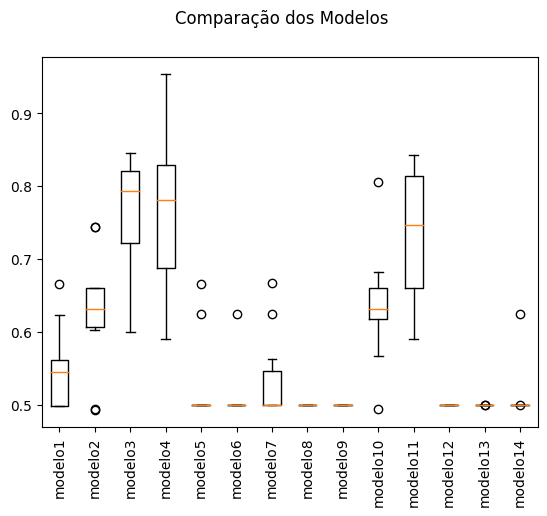

In [103]:
fig = plt.figure()
fig.suptitle("Comparação dos Modelos")
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.xticks(rotation=90)
plt.show()

O modelo campeão então foi a combinação de utilizar o class_weight='balanced' com learning_rate de 0.01 e n_estimators =100. Abaixo, fiz o predict na base de teste, o que me trouxe uma acurácia balanceada de 0.79. Para um modelo de tão difícil predição por conta do desbalanceamento extremo, considero um resultado positivo.


[LightGBM] [Info] Number of positive: 72, number of negative: 87073
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009276 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1017
[LightGBM] [Info] Number of data points in the train set: 87145, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Accuracy score =  0.7951762025994908


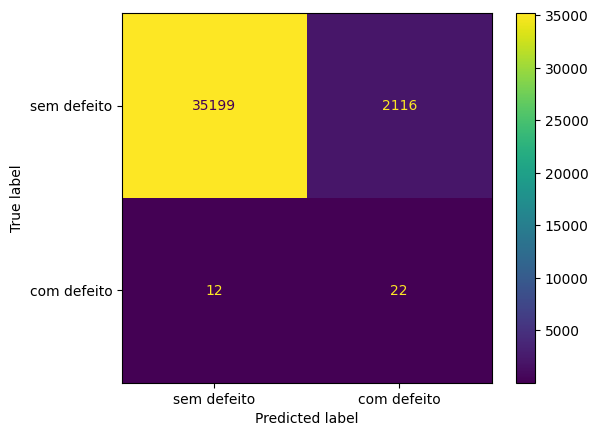

              precision    recall  f1-score   support

 sem defeito       1.00      0.94      0.97     37315
 com defeito       0.01      0.65      0.02        34

    accuracy                           0.94     37349
   macro avg       0.50      0.80      0.50     37349
weighted avg       1.00      0.94      0.97     37349



In [104]:
# Preparação do modelo
model = LGBMClassifier(class_weight='balanced',   learning_rate=0.01, n_estimators =100)
model.fit(X_train[explicativas], Y_train)

# Estimativa da acurácia no conjunto de teste
predictions = model.predict(X_test[explicativas])
print("Accuracy score = ", balanced_accuracy_score(Y_test, predictions))

# Matriz de confusão
cm = confusion_matrix(Y_test, predictions)
labels = ["sem defeito","com defeito"]
cmd = ConfusionMatrixDisplay(cm, display_labels=labels)
cmd.plot(values_format="d")
plt.show()
print(classification_report(Y_test, predictions, target_names=labels))